
**Step 3**

Target:
1. Increase model capacity at the end (add layer after GAP)
2.  Add rotation, our guess is that 7-10 degrees should be sufficient.
6.  Results:
    1.  Parameters: 9678
    2.  Best Training Accuracy: 98.76 (15th epoch)
    3.  Best Test Accuracy: 99.21 (15th epoch)
7.  Analysis:
    1.  It is a good model can be pushed further. There is no over fitting in the model so it is a good sign.
    3. From the graph we can see that there are oscillations in accuracy. We can fix that using LR scheduler. 

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))  
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Looking at data

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

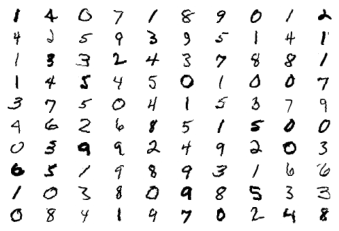

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
dropout_value= 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) 


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),            
        ) 

        self.pool1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
        )

        

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        
        
        


        self.pool2 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),            
        ) 

        

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )
        self.pool3 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        ) 

        self.convblock8= nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        
        self.gap= nn.Sequential(
            nn.AvgPool2d(kernel_size=3), 
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False) 
        )

         # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)    #input-(28,28) Output-(28,28)   RF=3   input channels=1 output channels=10
        x = self.convblock2(x)    #input-(28,28) Output-(28,28)   RF=5   input channels=10 output channels=16
        x = self.convblock3(x)    #input-(28,28) Output-(28,28)   RF=5   input channels=16 output channels=10
        x = self.pool1(x)         #input-(28,28) Output-(14,14)   RF=6   input channels=10 output channels=10
        x = self.convblock4(x)    #input-(14,14) Output-(14,14)   RF=10   input channels=10 output channels=16
        x = self.convblock5(x)    #input-(14,14) Output-(14,14)   RF=14   input channels=16 output channels=16
        x = self.pool2(x)         #input-(14,14) Output-(7,7)     RF=16   input channels=16 output channels=16
        x = self.convblock6(x)    #input-(7,7) Output-(7,7)       RF=16   input channels=16 output channels=10
        x = self.convblock7(x)    #input-(7,7) Output-(7,7)       RF=24   input channels=10 output channels=16
        x = self.pool3(x)         #input-(7,7) Output-(3,3)       RF=28   input channels=16 output channels=16
        x = self.convblock8(x)    #input-(3,3) Output-(3,3)       RF=44   input channels=16 output channels=16


        x = self.gap(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,440
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader,position=0, leave=True)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13118550181388855 Batch_id=468 Accuracy=92.26: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0919, Accuracy: 9715/10000 (97.15%)

EPOCH: 1


Loss=0.02594529651105404 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.1179734468460083 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.07535234838724136 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Loss=0.07679815590381622 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9873/10000 (98.73%)

EPOCH: 5


Loss=0.04601578414440155 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9862/10000 (98.62%)

EPOCH: 6


Loss=0.10107717663049698 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.02255786955356598 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.05978124216198921 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9893/10000 (98.93%)

EPOCH: 9


Loss=0.0446656234562397 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.013745054602622986 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.0817062258720398 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9899/10000 (98.99%)

EPOCH: 12


Loss=0.015319428406655788 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


Loss=0.02085067890584469 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.011819885112345219 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]



Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)



Text(0.5, 1.0, 'Test Accuracy')

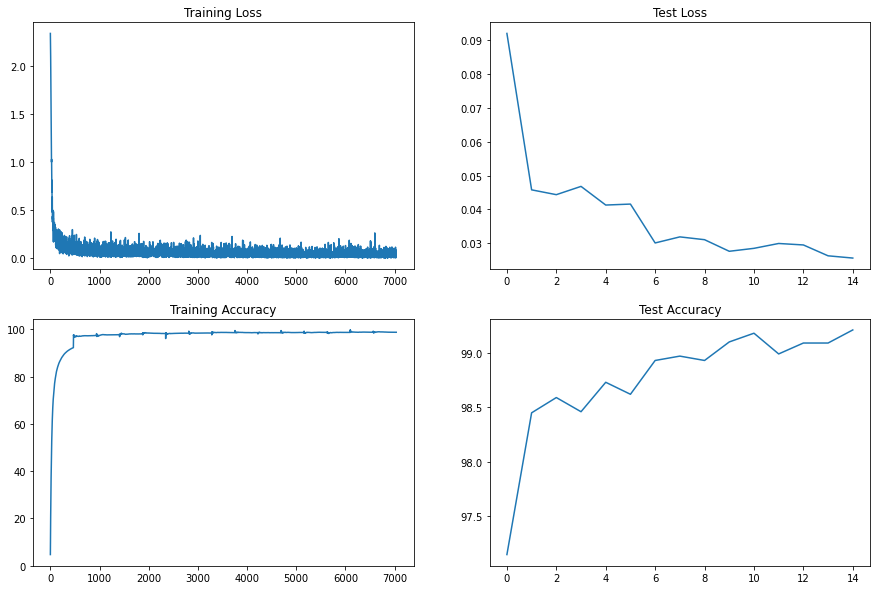

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")